# Segment images

In [1]:
import os
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from skimage import io
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from sklearn.cluster import KMeans
from scipy.stats import spearmanr

In [2]:
# Write function
# inputs = Pramaeters and directory of images
# wether to estimate size or not
# true size of bearing as parameter
# visualization is separate only in notebook
# save to disk or not

In [3]:
wd = os.getcwd()
image_name = "IMG_0269_clean.JPG" #IMG_0011.JPG
image = io.imread(wd+"/"+image_name)
image_gray = rgb2gray(image) # gray image

# binarize image ot be black and white
global_thresh = threshold_otsu(image_gray) 
binary_global = image_gray > global_thresh
bw = np.invert(binary_global)

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
props = regionprops_table(label_image, properties=('centroid',
                                                   'bbox',
                                                   'orientation',
                                                   'axis_major_length',
                                                   'axis_minor_length',
                                                   'area',
                                                   'area_filled'))

props_df = pd.DataFrame(props)

# cluster to only include beetles and not noise
clust_count = 2 # PARAM
X = np.array(props_df[['axis_major_length', 'axis_minor_length']])
kmeans = KMeans(n_clusters=clust_count).fit(X)
props_df['kmeans_label'] = kmeans.labels_

# select only the cluster with largest organisms
max_label = int(props_df.kmeans_label[props_df['area'] == props_df['area'].max()])
select_df = props_df[props_df['kmeans_label']==max_label]

# create a buffer around image borders
buffer_size = 50 # PARAM
coord_df = select_df.loc[:,['bbox-0','bbox-1','bbox-2','bbox-3']].copy()
coord_df = coord_df.reset_index()
coord_df.loc[:,['bbox-0','bbox-1']] = coord_df-buffer_size
coord_df.loc[:,['bbox-2','bbox-3']] = coord_df+buffer_size

# crop images and add to a list
img_lst = []
bw_img_lst = []
for i in range(len(coord_df)):
    # color image
    coord_i = coord_df.iloc[i]
    crop_img = image[coord_i['bbox-0']:coord_i['bbox-2'], coord_i['bbox-1']:coord_i['bbox-3']]
    img_lst.append(crop_img)
    # bw image
    crop_bw_img = bw[coord_i['bbox-0']:coord_i['bbox-2'], coord_i['bbox-1']:coord_i['bbox-3']]
    bw_img_lst.append(crop_bw_img)

In [4]:
# save images and metadata to disk
dir_lst = wd.split("\\")
subset_name = dir_lst[-1]
vial_name = dir_lst[-2]
species_name = dir_lst[-3]
metadata_df = pd.DataFrame(columns=['species', 'vial', 'subset', "original_image", 'croped_image_name', 'pixel_area'])
for i in range(len(img_lst)):
    img_area = np.unique(bw_img_lst[i], return_counts=True)[1][1]
    croped_image_name = vial_name+"_"+subset_name+'_'+str(i)+".jpg"
    metadata_df.loc[i] = [species_name, vial_name, subset_name, image_name, croped_image_name, img_area]
    io.imsave(wd+'/'+croped_image_name, img_lst[i])          
metadata_df.to_csv(image_name[:-4]+'_metadata.csv', index=False)

## Visualize data

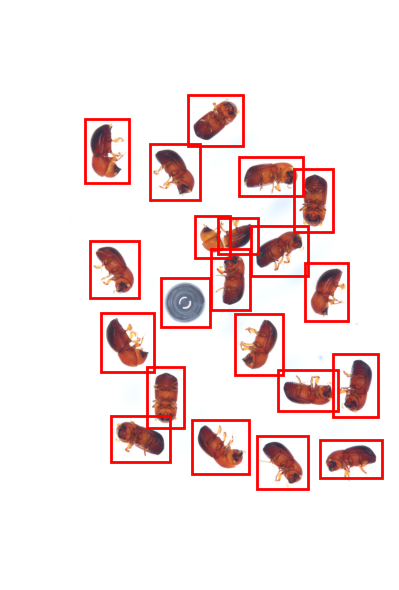

In [5]:
# plot boxes that will be used to extract 
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image)

for i in range(len(coord_df)):
    data_i = coord_df.iloc[i]
    minr = data_i['bbox-0']
    minc = data_i['bbox-1']
    maxr = data_i['bbox-2']
    maxc =data_i['bbox-3']
    
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

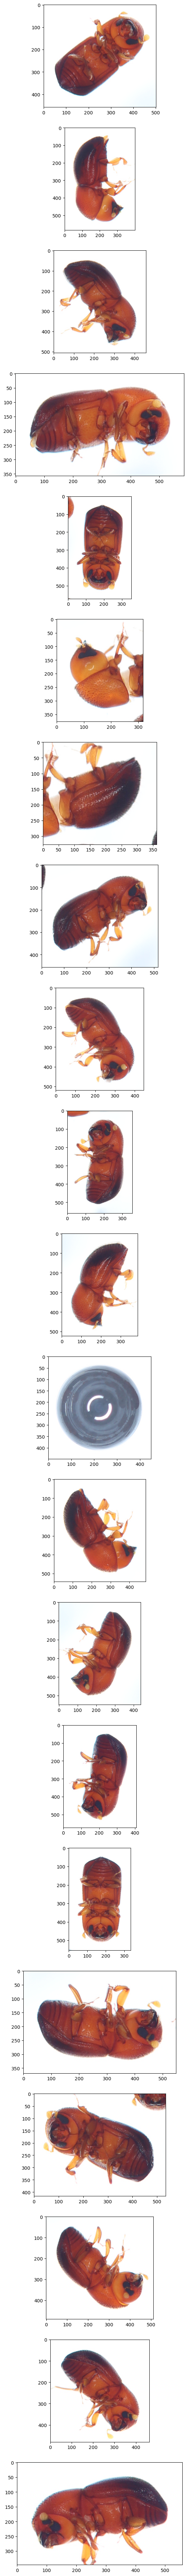

In [6]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, ax = plt.subplots(len(img_lst),1)
for i in range(len(img_lst)):
    f.set_figwidth(100)
    f.set_figheight(100)
    ax[i].imshow(img_lst[i])

# Classify circle and calcualte relative size of beetles
(This is based on the segmentation part of this script [both need to go into the same class])

In [7]:
# SIZE ESTIMATE
# classify circle image
# give relative surface area based on circle classified image

All images printed (21)
All images printed (21)
All images printed (21)


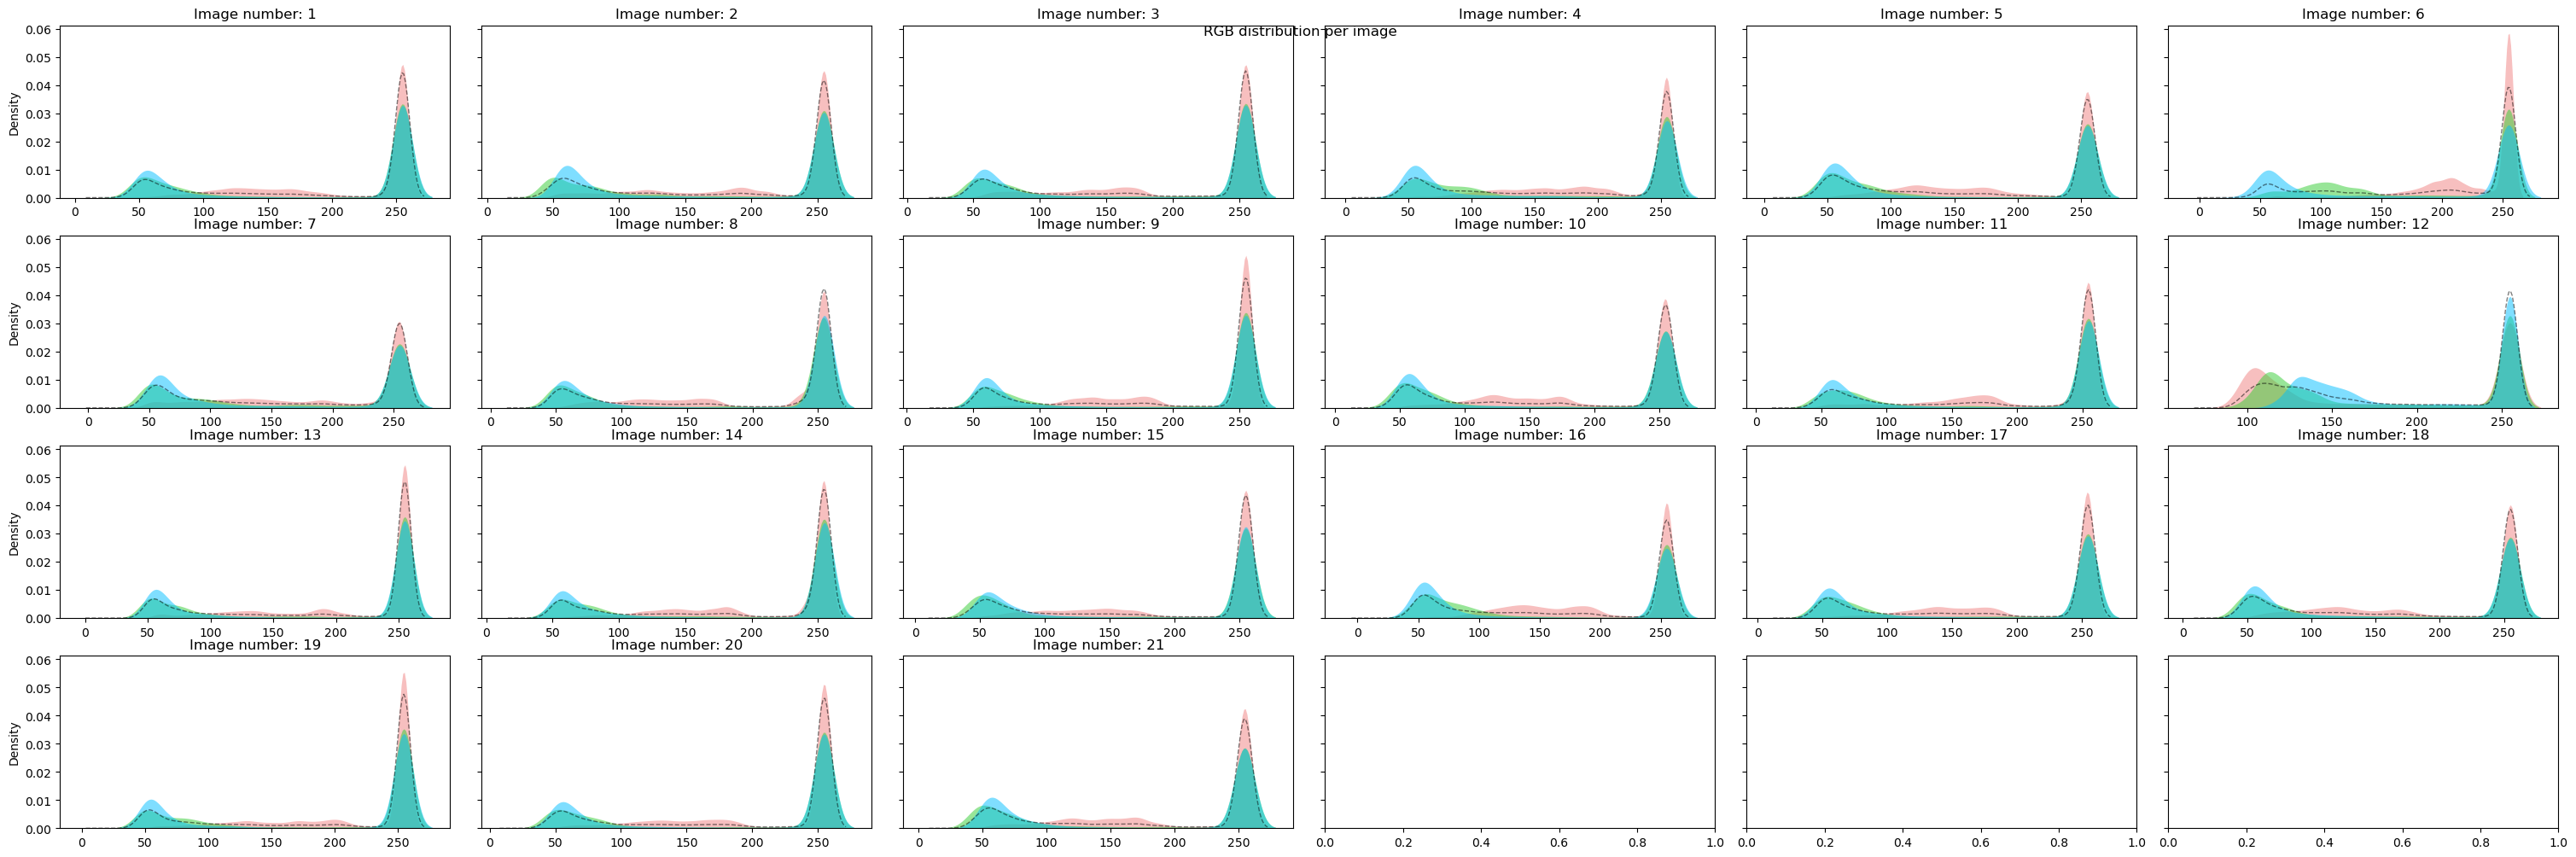

In [8]:
# turn list of images into array
img_ar = np.copy(np.array(img_lst, dtype='object'))

# plot pixel distribution values for all iamges in a class
fig_rows = 4
fig_cols = ceil(len(img_lst)/fig_rows)

# define plot layout
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(30, 10), sharey=True)
fig.tight_layout()
fig.suptitle('RGB distribution per image')

# initialize lists to store data in
r_ar_lst = []
g_ar_lst = []
b_ar_lst = []
all_ar_lst = []
l=0
for i in range(0,fig_rows):
    for j in range(0,fig_cols):
        if l < len(img_lst):
            # calcualte mean pixel arrays
            img_var = img_ar[l]
            r_ar = img_var[:,:,0].flatten()
            g_ar = img_var[:,:,1].flatten()
            b_ar = img_var[:,:,2].flatten()
            all_ar = img_var.flatten()
            
            # collect data in lists
            r_ar_lst.append(r_ar)
            g_ar_lst.append(g_ar)
            b_ar_lst.append(b_ar)
            all_ar_lst.append(all_ar) 
            
            # plot data
            fig = sns.kdeplot(ax=axes[i][j], data=r_ar, color='lightcoral', fill=True, alpha=.5, linewidth=0)
            fig = sns.kdeplot(ax=axes[i][j], data=g_ar, color='limegreen', fill=True, alpha=.5, linewidth=0)
            fig = sns.kdeplot(ax=axes[i][j], data=b_ar, color='deepskyblue', fill=True, alpha=.5, linewidth=0)
            fig = sns.kdeplot(ax=axes[i][j], data=all_ar, color='black', fill=False, alpha=.5, linewidth=1, linestyle='--')
            fig = axes[i][j].set_title('Image number: '+str(l+1))
            l += 1
        else:
            print("All images printed ("+str(l)+")")
fig.figure.savefig("Image_RGB_density_distribution.png")
plt.show()

In [9]:
col_lst = all_ar_lst
temp_dist_ar = np.zeros(shape=(255, len(col_lst)))
# get frequency of values at each rgb value
for i in range(len(col_lst)):
    unique, counts = np.unique(col_lst[i], return_counts=True)
    temp_dict = dict(zip(unique, counts))
    for j in temp_dict.keys():
        temp_dist_ar[j-1][i] = temp_dict[j]

<AxesSubplot:>

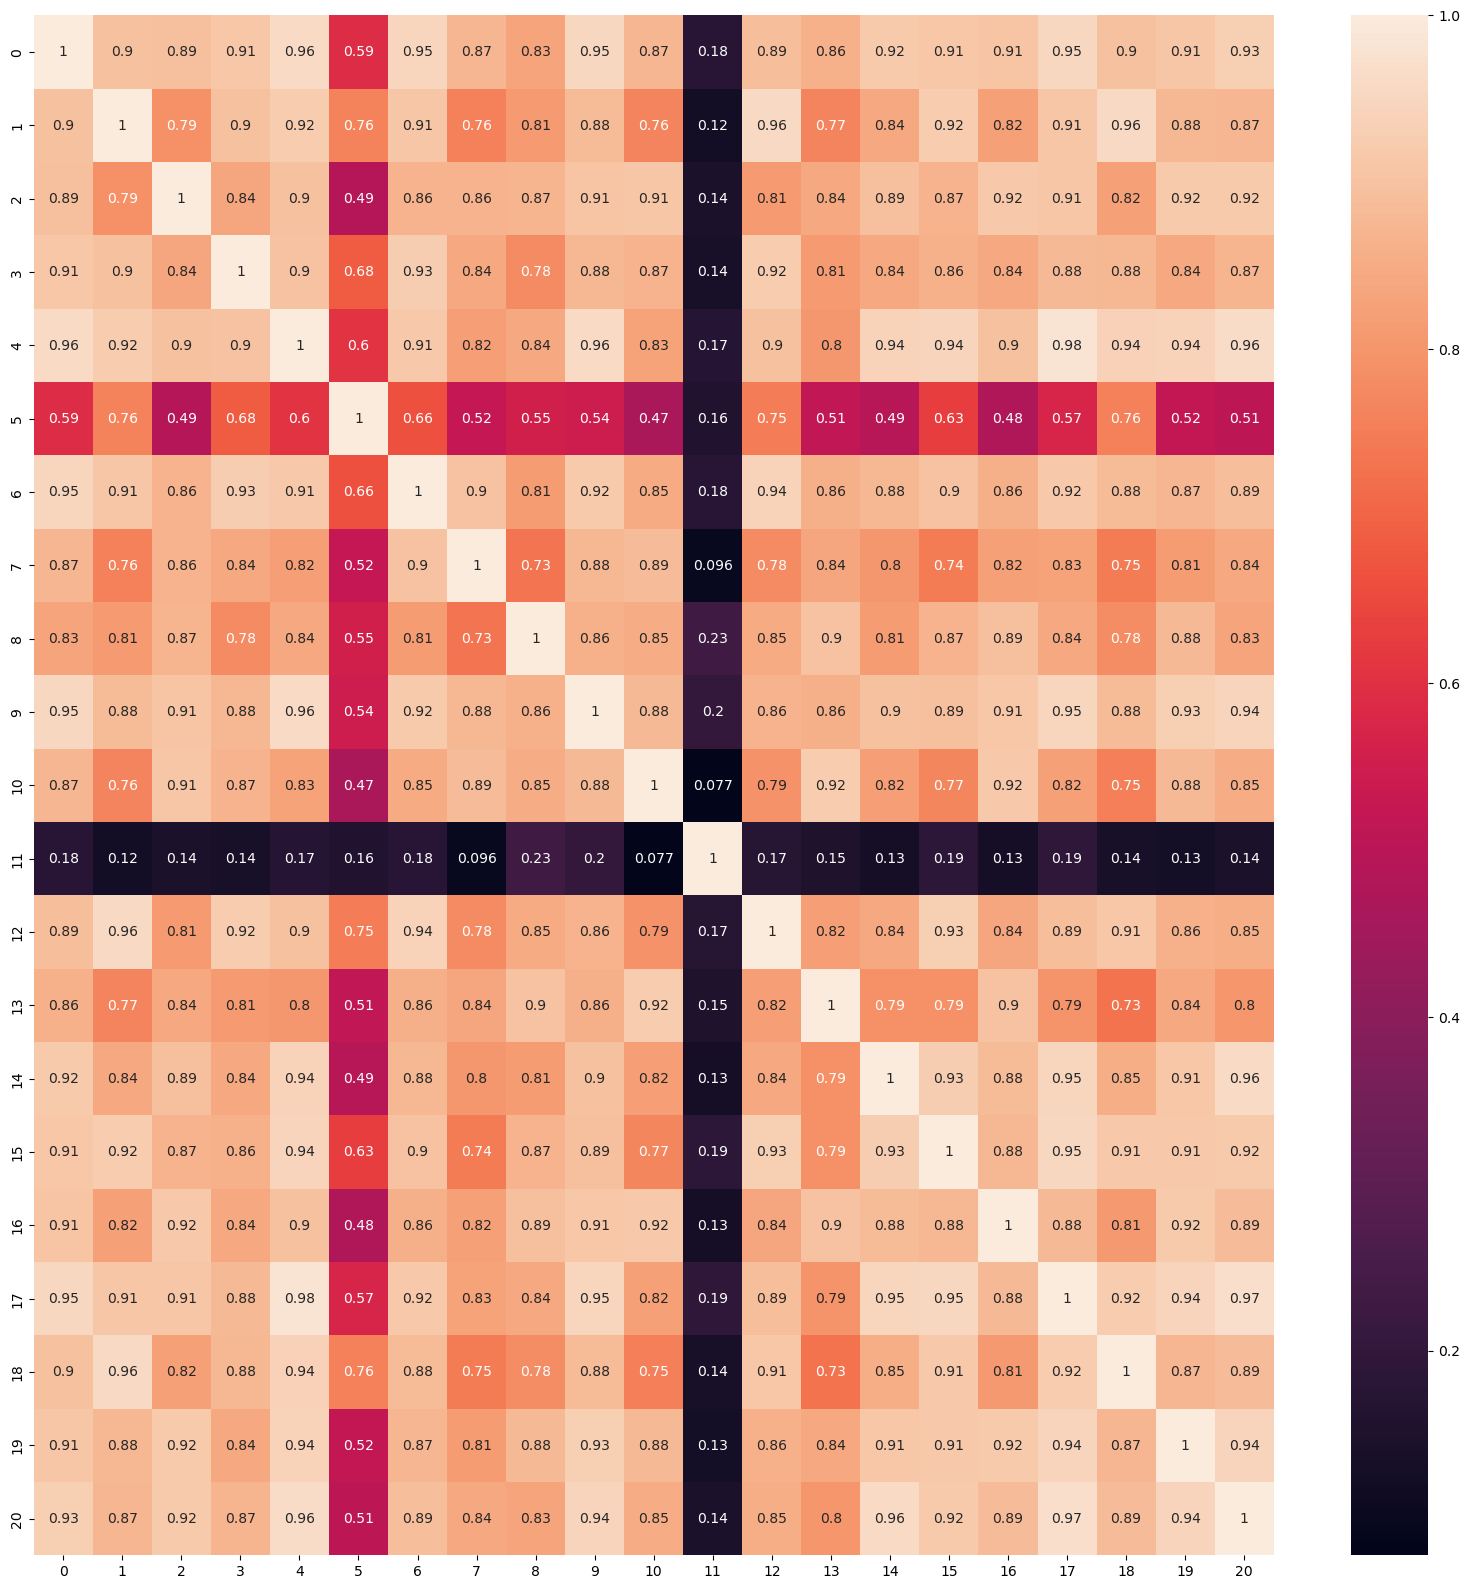

In [10]:
# Spearman correlation
corr_ar = np.array(spearmanr(temp_dist_ar, axis=0))
corr_coef_ar = corr_ar[0,:,:]
corr_pval_ar = corr_ar[1,:,:]
corr_sum_ar = corr_coef_ar.sum(axis=0)

# plot heatmap
corr_df = pd.DataFrame(corr_coef_ar)
plt.figure(figsize=(20,20))
sns.heatmap(corr_df, annot=True)

<AxesSubplot:>

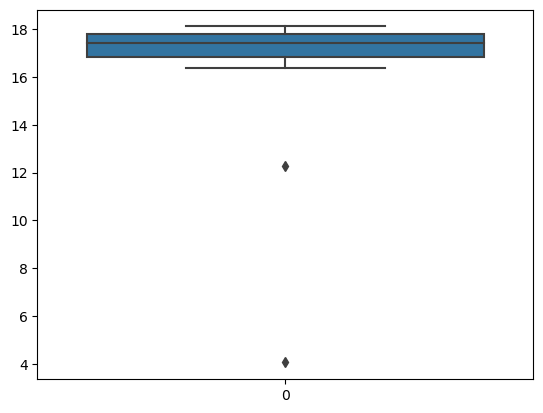

In [11]:
# plot boxplot of summmed correlation
sns.boxplot(corr_sum_ar)

11


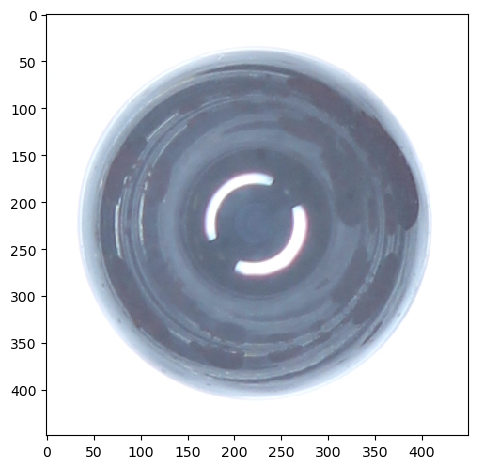

In [17]:
# print image classified as the ball bearing
bb_idx = corr_sum_ar.argmin()
print(bb_idx)
io.imshow(img_lst[bb_idx])

In [13]:
# save classification into image name and in csv
# fill ball in bearing image and save surface area